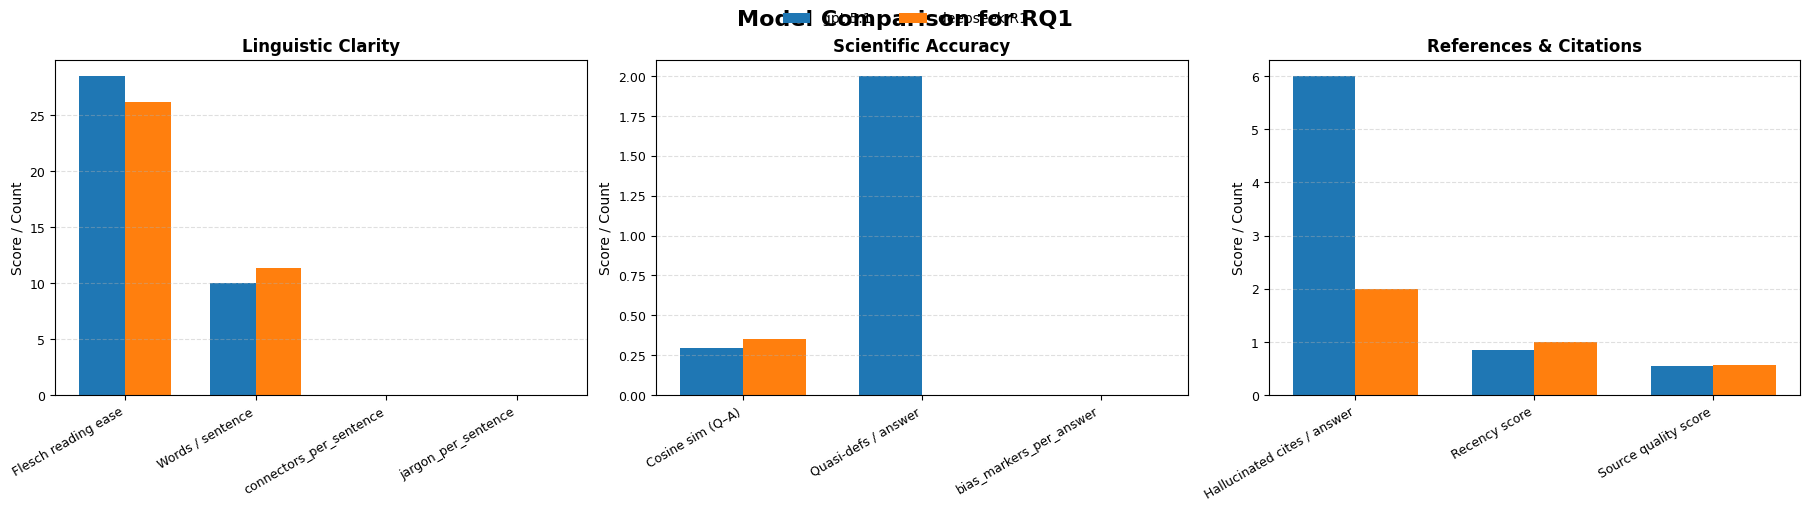

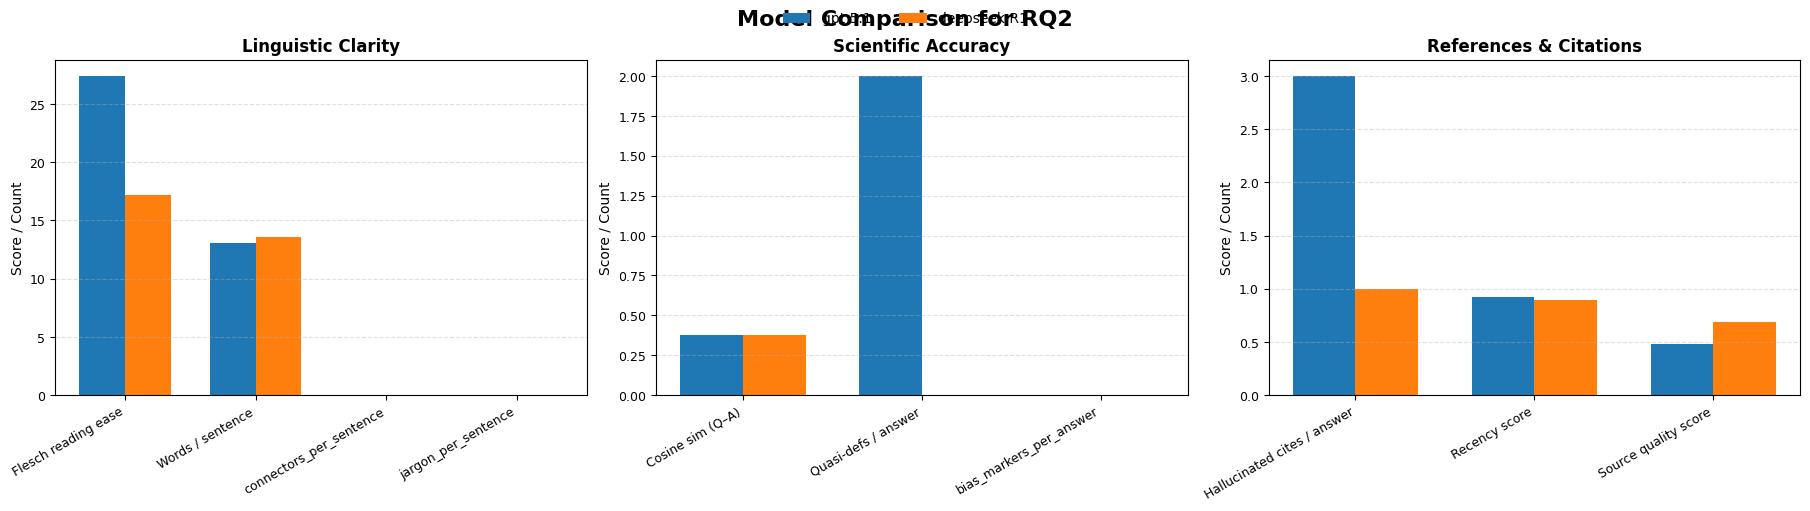

In [4]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# ---------- Load & flatten JSON ----------
json_path = Path("rubric_results_RQ1_RQ2.json")

with open(json_path, "r") as f:
    data = json.load(f)

records = []
for rq, models in data.items():
    for model_name, categories in models.items():
        for category_name, metrics in categories.items():
            for metric_name, value in metrics.items():
                records.append({
                    "RQ": rq,
                    "model": model_name,
                    "category": category_name,
                    "metric": metric_name,
                    "value": value
                })

df = pd.DataFrame(records)

# Nice labels for plotting
pretty_metric_names = {
    "words_per_sentence": "Words / sentence",
    "flesch_reading_ease": "Flesch reading ease",
    "quasi_definitions_per_answer": "Quasi-defs / answer",
    "cosine_similarity_q_a": "Cosine sim (Q–A)",
    "hallucinated_citations_per_answer": "Hallucinated cites / answer",
    "source_quality_score": "Source quality score",
    "recency_score": "Recency score"
}

df["metric_pretty"] = df["metric"].map(pretty_metric_names).fillna(df["metric"])

# ---------- Plotting function ----------
def plot_rq(rq_name: str, df_rq: pd.DataFrame):
    """
    Create one figure for a given RQ with 3 subplots:
    linguistic_clarity, scientific_accuracy, references.
    """
    categories = ["linguistic_clarity", "scientific_accuracy", "references"]
    pretty_cat_names = {
        "linguistic_clarity": "Linguistic Clarity",
        "scientific_accuracy": "Scientific Accuracy",
        "references": "References & Citations"
    }

    fig, axes = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)
    fig.suptitle(f"Model Comparison for {rq_name}", fontsize=16, fontweight="bold")

    for ax, cat in zip(axes, categories):
        df_cat = df_rq[df_rq["category"] == cat]

        if df_cat.empty:
            ax.set_visible(False)
            continue

        # Pivot so rows = metrics, columns = models, values = scores
        pivot = df_cat.pivot(index="metric_pretty", columns="model", values="value")

        # Keep a stable model order if present
        model_order = [m for m in ["gpt-5.1", "deepseek-R1"] if m in pivot.columns]
        pivot = pivot[model_order]

        # ---- Grouped bar chart ----
        x = np.arange(len(pivot.index))  # metrics
        width = 0.35  # bar width

        for i, model in enumerate(pivot.columns):
            ax.bar(x + (i - (len(pivot.columns)-1)/2) * width,
                   pivot[model].values,
                   width,
                   label=model.replace("-", " "))

        ax.set_title(pretty_cat_names.get(cat, cat), fontsize=12, fontweight="semibold")
        ax.set_xticks(x)
        ax.set_xticklabels(pivot.index, rotation=30, ha="right", fontsize=9)
        ax.tick_params(axis="y", labelsize=9)
        ax.grid(axis="y", linestyle="--", alpha=0.4)

        # Light y-axis label to hint "score scale"
        ax.set_ylabel("Score / Count", fontsize=10)

    # Put legend once for the whole figure
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=2, frameon=False)

    plt.show()

# ---------- Generate plots for all RQs ----------
for rq_name in sorted(df["RQ"].unique()):
    df_rq = df[df["RQ"] == rq_name]
    plot_rq(rq_name, df_rq)

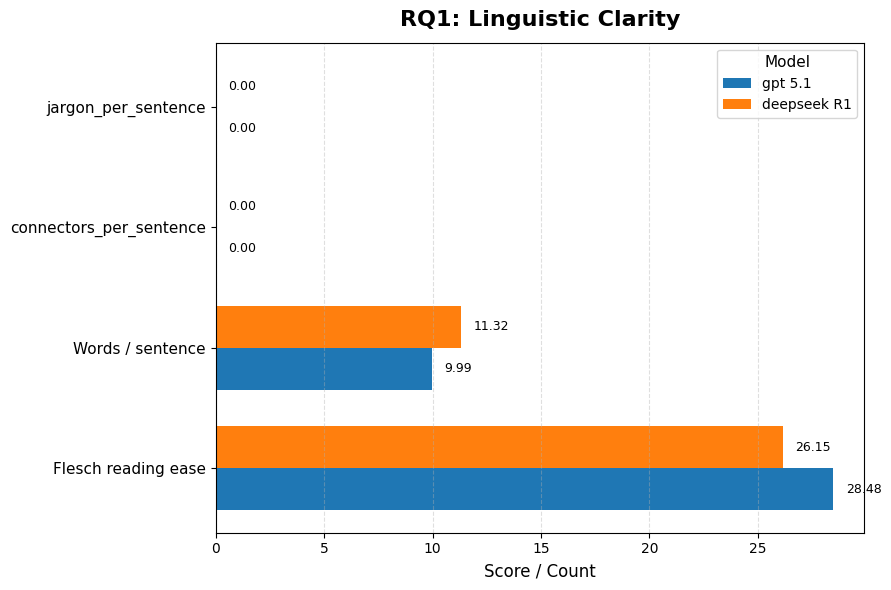

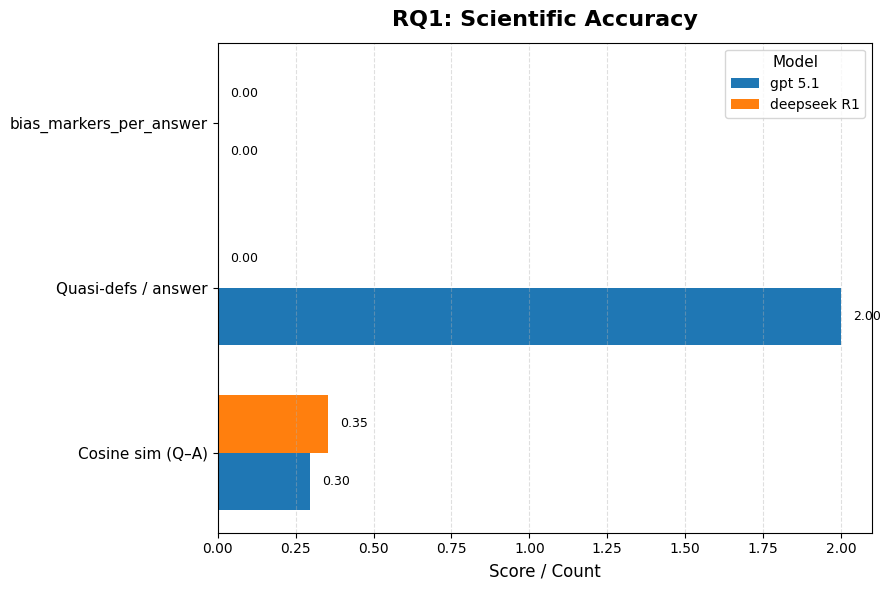

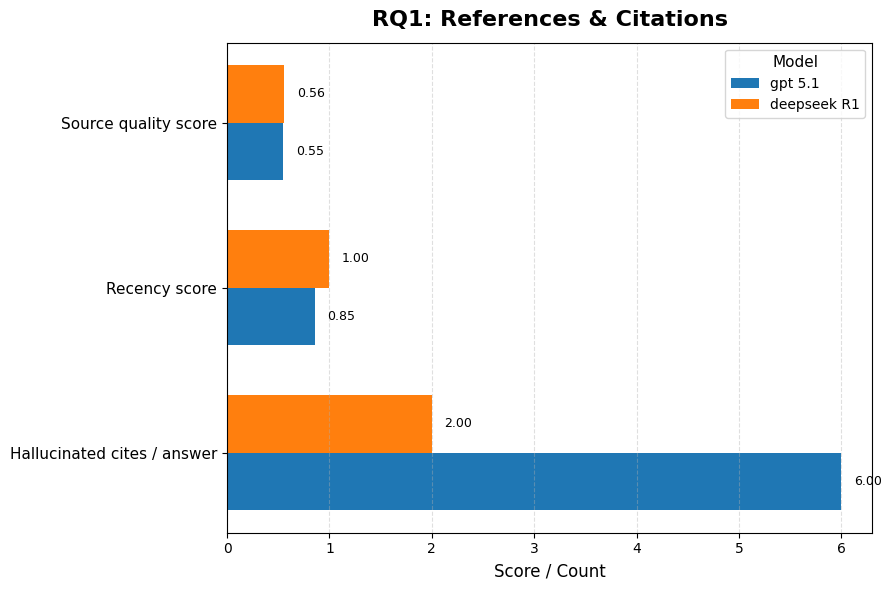

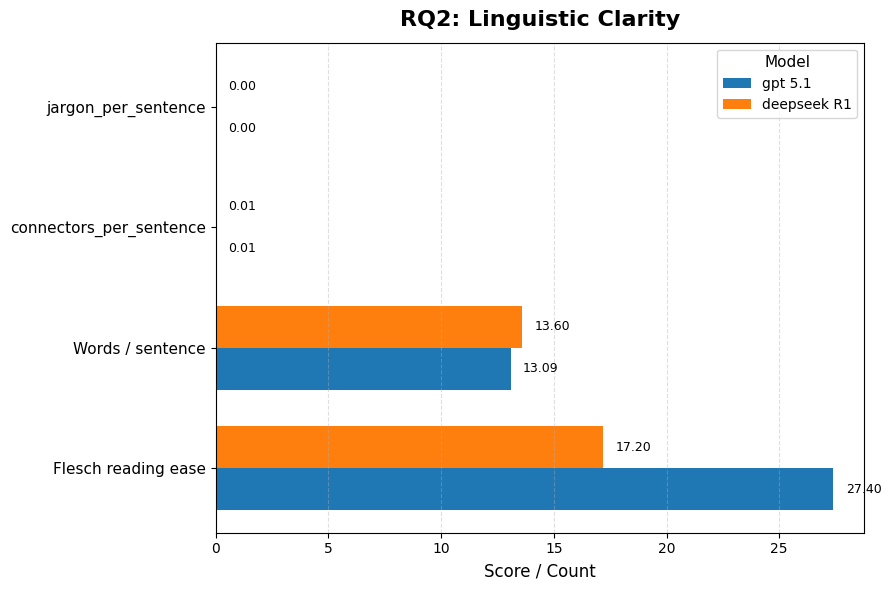

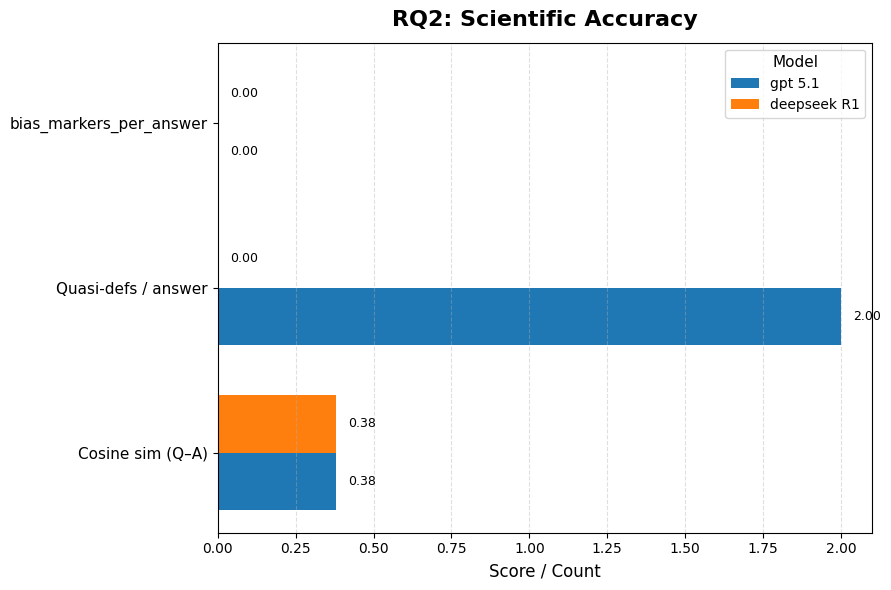

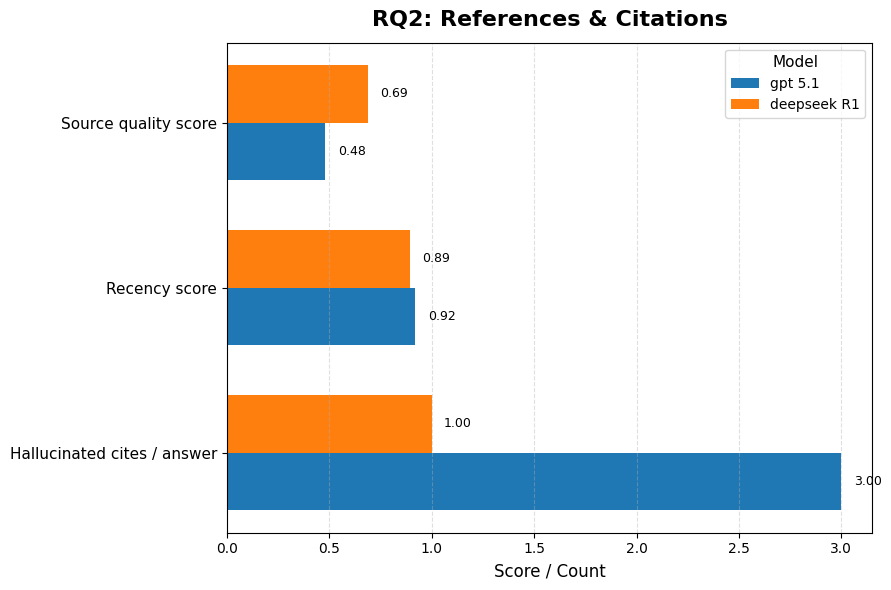

In [5]:
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------- Load & flatten JSON -------------

json_path = Path("rubric_results_RQ1_RQ2.json")

with open(json_path, "r") as f:
    data = json.load(f)

records = []
for rq, models in data.items():
    for model_name, categories in models.items():
        for category_name, metrics in categories.items():
            for metric_name, value in metrics.items():
                records.append({
                    "RQ": rq,
                    "model": model_name,
                    "category": category_name,
                    "metric": metric_name,
                    "value": value
                })

df = pd.DataFrame(records)

# ------------- Pretty names -------------

pretty_metric_names = {
    "words_per_sentence": "Words / sentence",
    
    "flesch_reading_ease": "Flesch reading ease",
    "quasi_definitions_per_answer": "Quasi-defs / answer",
    "cosine_similarity_q_a": "Cosine sim (Q–A)",
    "hallucinated_citations_per_answer": "Hallucinated cites / answer",
    "source_quality_score": "Source quality score",
    "recency_score": "Recency score"
}

pretty_cat_names = {
    "linguistic_clarity": "Linguistic Clarity",
    "scientific_accuracy": "Scientific Accuracy",
    "references": "References & Citations"
}

df["metric_pretty"] = df["metric"].map(pretty_metric_names).fillna(df["metric"])

# ------------- Plotting helper -------------

def plot_grouped_horizontal_bars(rq_name: str, category_name: str, df_subset: pd.DataFrame):
    """
    One figure: horizontal grouped bars for all metrics in a given RQ & category.
    Models are grouped per metric.
    """
    if df_subset.empty:
        return

    # Pivot: rows = metrics, columns = models
    pivot = df_subset.pivot(index="metric_pretty", columns="model", values="value")

    # Ensure consistent model order if available
    model_order = [m for m in ["gpt-5.1", "deepseek-R1"] if m in pivot.columns]
    pivot = pivot[model_order]

    metrics = pivot.index.tolist()
    n_metrics = len(metrics)
    n_models = len(pivot.columns)

    # Positions for metrics
    base_y = np.arange(n_metrics)

    # Bar height and offsets for models
    bar_height = 0.35
    total_height = bar_height * n_models
    offsets = np.linspace(-total_height/2 + bar_height/2,
                          total_height/2 - bar_height/2,
                          n_models)

    fig, ax = plt.subplots(figsize=(9, 6))
    title = f"{rq_name}: {pretty_cat_names.get(category_name, category_name)}"
    ax.set_title(title, fontsize=16, fontweight="bold", pad=12)

    # Plot bars
    for i, model in enumerate(pivot.columns):
        y_pos = base_y + offsets[i]
        values = pivot[model].values
        bars = ax.barh(y_pos, values, height=bar_height, label=model.replace("-", " "))

        # Add value labels at the end of each bar
        for bar in bars:
            width = bar.get_width()
            ax.text(width + max(pivot.max()) * 0.02,   # a bit to the right of the bar
                    bar.get_y() + bar.get_height() / 2,
                    f"{width:.2f}",
                    va="center",
                    ha="left",
                    fontsize=9)

    # Y-axis: metrics
    ax.set_yticks(base_y)
    ax.set_yticklabels(metrics, fontsize=11)

    # X-axis label
    ax.set_xlabel("Score / Count", fontsize=12)

    # Grid for readability
    ax.grid(axis="x", linestyle="--", alpha=0.4)

    # Legend
    ax.legend(title="Model", fontsize=10, title_fontsize=11, loc="best")

    plt.tight_layout()
    plt.show()


# ------------- Generate all plots -------------

for rq_name in sorted(df["RQ"].unique()):
    df_rq = df[df["RQ"] == rq_name]
    for category in ["linguistic_clarity", "scientific_accuracy", "references"]:
        df_cat = df_rq[df_rq["category"] == category]
        plot_grouped_horizontal_bars(rq_name, category, df_cat)